In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate as integrate

In [2]:
class Graph:
    
    def __init__(self):
        self.x, self.y, self.edges = read_coords('coords.txt')
        self.neighbors = read_neighbors('neighbors.txt')
        self.cost = read_cost('cost.txt')
        self.length, self.xcoeff, self.ycoeff = calc_length_and_coeff(self)
        

In [3]:
def read_coords(file_name):
    
    file = open(file_name, 'r')
    data_list = file.readlines()
    for i in range(len(data_list)):
        data_list[i] = list(map(int, data_list[i].split(' ')))
    file.close()
    
    x, y = [], []
    edges = []
    ch = 0
    for i in range(len(data_list)):
        edges.append([])
        for j in range(data_list[i][0]):
            x.append(data_list[i][2*j+2])
            y.append(data_list[i][2*j+1])
            edges[i].append(ch)
            ch += 1
    return x, y, edges

In [4]:
def read_neighbors(file_name):
    
    file = open(file_name, 'r')
    neighbors = file.readlines()
    
    for i in range(len(neighbors)):
        neighbors[i] = list(map(int, neighbors[i].split(' ')))
        
    file.close()
    return neighbors

In [5]:
def read_cost(file_name):
    
    file = open(file_name, 'r')
    cost = file.readlines()
    cost = list(map(int, cost))
    return cost

In [6]:
def calc_length_and_coeff(graph):
    
    lenght = []
    xcoeff = []
    ycoeff = []
    
    for edge in graph.edges:
        if len(edge) == 2:
            i, j = edge[0], edge[1]
            x = [graph.x[i], graph.x[j]]
            y = [graph.y[i], graph.y[j]]
        else:
            i, j, k = edge[0], edge[1], edge[2]
            x = [graph.x[i], graph.x[j], graph.x[k]]
            y = [graph.y[i], graph.y[j], graph.y[k]]
            
        x0, y0, l0 = find_coeff(x, y)
        xcoeff.append(x0)
        ycoeff.append(y0)
        lenght.append(l0)
        
    return (lenght, xcoeff, ycoeff)

In [7]:
def find_coeff(x, y):
    
    if len(x) == 2:
        t_0 = 0.
        t_max = np.linalg.norm([x[1]-x[0], y[1]-y[0]])
        
        a = np.array([[1., t_0],
                      [1., t_max]])
    else:
        t_0 = 0.
        t_1 = np.linalg.norm([x[1]-x[0], y[1]-y[0]])
        t_max = t_1 + np.linalg.norm([x[2]-x[1], y[2]-y[1]])
        a = np.array([[1., t_0, t_0**2],
                      [1., t_1, t_1**2],
                      [1., t_max, t_max**2]])
        
    p_x = scipy.linalg.solve(a, x) 
    p_y = scipy.linalg.solve(a, y)
    return (p_x, p_y,t_max)

In [8]:
g1 = Graph()

In [9]:
#xcoeff- одна строчка из Graph.xcoeff, соответствующая интересующему нас сплайну, t - точка, в которой ищем значения

def P_x(xcoeff, t):
    
    if len(xcoeff) == 2:
        return xcoeff[0] + xcoeff[1]*t
    else:
        return xcoeff[0] + xcoeff[1]*t + xcoeff[2]*t**2
    
def P_y(ycoeff, t):
    
    if len(ycoeff) == 2:
        return ycoeff[0] + ycoeff[1]*t
    else:
        return ycoeff[0] + ycoeff[1]*t + ycoeff[2]*t**2
    

In [10]:
# тестовая функция движения на расстояние km от начала i-го сплайна, возвращает номер сплайна и значение параметра t на нём
# не нужна непосредственно в реализации карты, просто проверяет корректность работы

def go(i, km):
    now = 0
    t = 0
    prev = 0
    while (now < km):
        while (t < g1.length[i]) and (now < km):
            t+=1
            now = s(i,t)+prev
        if now >= km:
            return (i, t)
        
        i_new , dist, t = jump(i)
        if i_new == -1: 
            return (i, g1.length[i])
        i = i_new
        prev = now + dist    

In [11]:
# функция вычисления натурального параметра s в точке t для i-го сплайна карты
def s(i,t):
    if len(g1.edges[i]) == 2:
        return t
    
    x = np.arange(0.0, t+0.1, max(0.1, t/10))
    y = f(i, x)
    rez = integrate.simps(y, x)
    return rez

# вспомогательная функция, возвращает список значение подинтегральной функции в точках разбиения
def f(i, x):
    lst = []
    for h in x:
        lst.append(math.sqrt((g1.xcoeff[i][1]+2*g1.xcoeff[i][2]*h)**2 + (g1.ycoeff[i][1]+2*g1.ycoeff[i][2]*h)**2))
    return lst

In [12]:
# функция скачка на новый сплайн, возвращает номер нового сплайна, расстояние "скачка" и обнуляет параметр сплайна t 

def jump(i, j=0):
    i_new = g1.neighbors[i][j]
    if i_new == -1:
        return (-1, 0, 0)
    
    num_0 = g1.edges[i][-1]
    num_1 = g1.edges[i_new][0]
    x_0 = g1.x[num_0]
    y_0 = g1.y[num_0]
    x_1 = g1.x[num_1]
    y_1 = g1.y[num_1]
    
    dist = np.linalg.norm([x_1 - x_0, y_1 - y_0])
    return (i_new, dist, 0)

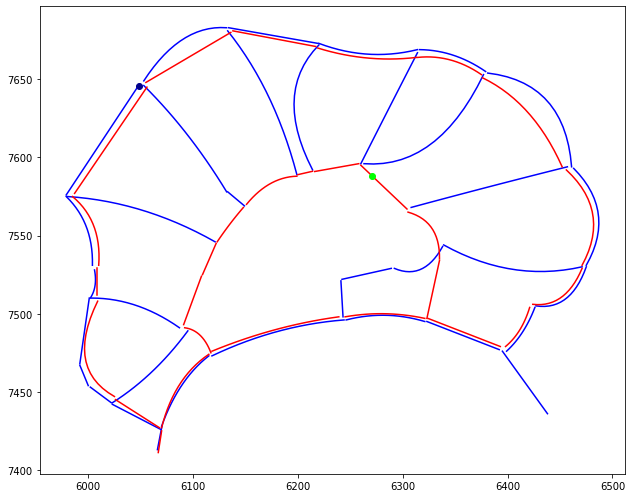

In [13]:
# тестовый блок, передавая в go произвольные координаты можно посмотреть, куда уедет наша точка
i_start = 0
path = 500

i_0, t0 = go(i_start, path)
plt.figure(figsize=(10.5, 8.6))

for i in range(len(g1.edges)):
    t = np.arange(0.0, g1.length[i] + 1, g1.length[i]/15)
    x_val = [P_x(g1.xcoeff[i], h) for h in t ]
    y_val = [P_x(g1.ycoeff[i], h) for h in t ]
    if i < 35: 
        color = 'blue'
    else: 
            color = 'red'
    plt.plot(x_val, y_val, color)
    
plt.plot(P_x(g1.xcoeff[i_start], 0), P_y(g1.ycoeff[i_start], 0), 'o', color = 'darkblue') #тёмно-синяя - точка старта
plt.plot(P_x(g1.xcoeff[i_0], t0), P_y(g1.ycoeff[i_0], t0), 'o', color = 'lime')           #лаймовая - куда она уехала
plt.show()

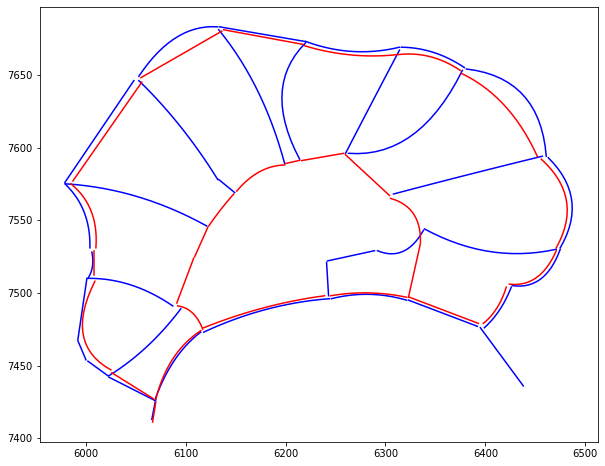

In [14]:
# тестовый блок, рисует, как выглядит карта

plt.figure(figsize=(10, 8))

for i in range(len(g1.edges)):
    t = np.arange(0.0, g1.length[i] + 1, g1.length[i]/15)
    x_val = [P_x(g1.xcoeff[i], h) for h in t ]
    y_val = [P_x(g1.ycoeff[i], h) for h in t ]
    if i < 35: 
        color = 'blue'
    else: 
            color = 'red'
    plt.plot(x_val, y_val, color)

plt.show()